### Feature Correlation Heatmap

Loads the dataset, defines core features, computes correlations, and draws a heatmap

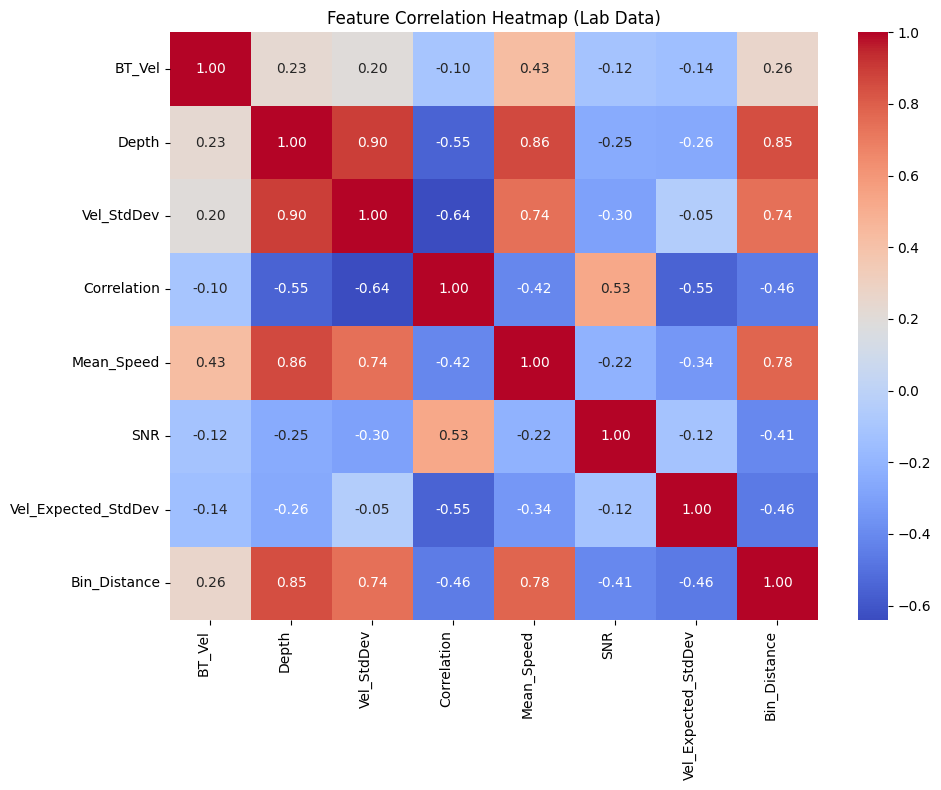

In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the processed Excel file
input_path = r'C:\Users\thtuh\Documents\Processed_Flow_Rate_NEW_BIG_Data_with_ABS.xlsx'
final_df = pd.read_excel(input_path)

# List of features to check (Modify this to add/remove features dynamically)
features_to_check = [
    'BT_Vel', 'Depth', 'Vel_StdDev', 'Correlation', 
    'Mean_Speed', 'SNR', 'Vel_Expected_StdDev', 
    'Bin_Distance'
]

# Ensure selected features exist in the DataFrame
available_features = [feature for feature in features_to_check if feature in final_df.columns]

# Exclude the 'Flow Rate' column and select only available features
features_only_df = final_df[available_features]

# Calculate the correlation matrix
correlation_matrix = features_only_df.corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", cbar=True)
plt.title("Feature Correlation Heatmap (Lab Data)")
plt.xticks(rotation=90, ha='right')  # Rotate x-axis labels for better readability
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


### Stratified Cross-Validation
Runs stratified K-Fold over the candidate models and ranks them by mean R² (± std) and MSE.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, KBinsDiscretizer
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.base import clone

# === Load and preprocess dataset ===
output_path = r"C:\Users\thtuh\Documents\Processed_Flow_Rate_NEW_BIG_Data_with_ABS.xlsx"
lab_data = pd.read_excel(output_path)

# Define features
numeric_features = ['BT_Vel', 'Depth', 'Vel_StdDev', 'Correlation', 'Mean_Speed', 
                    'SNR', 'Vel_Expected_StdDev', 'Bin_Distance']
lab_data_numeric = lab_data[numeric_features].fillna(lab_data[numeric_features].mean(numeric_only=True))

X = lab_data_numeric.drop(columns=['BT_Vel'])
y = lab_data_numeric['BT_Vel'].fillna(lab_data_numeric['BT_Vel'].mean())

# === Bin target for stratified sampling ===
n_bins = 10
binner = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy='quantile')
y_binned = binner.fit_transform(y.values.reshape(-1, 1)).ravel()

# === Define stratified cross-validation ===
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# === Define models ===
models = {
   # "Linear Regression": LinearRegression(),
   # "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(random_state=42, n_estimators=100),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42, n_estimators=100),
    #"SVR": SVR(kernel='rbf', C=1.0, epsilon=0.1),
    "XGBoost": XGBRegressor(random_state=42, n_estimators=100, learning_rate=0.1),
    "LightGBM": LGBMRegressor(random_state=42, n_estimators=100, learning_rate=0.1),
    "CatBoost": CatBoostRegressor(random_state=42, verbose=0),
    "Stacking Regressor": StackingRegressor(
        estimators=[
            ('rf', RandomForestRegressor(random_state=42)),
            ('gb', GradientBoostingRegressor(random_state=42))
        ],
        final_estimator=GradientBoostingRegressor(random_state=42)
    )
}

# === Run cross-validation ===
cv_results = []

for name, model in models.items():
    print(f"\nCross-validating: {name}")
    r2_scores = []
    mse_scores = []

    try:
        for train_idx, test_idx in skf.split(X, y_binned):
            X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
            y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

            pipeline = make_pipeline(StandardScaler(), clone(model))
            pipeline.fit(X_train, y_train)
            y_pred = pipeline.predict(X_test)

            r2_scores.append(r2_score(y_test, y_pred))
            mse_scores.append(mean_squared_error(y_test, y_pred))

        cv_results.append({
            "Model": name,
            "Mean R²": np.mean(r2_scores),
            "Std R²": np.std(r2_scores),
            "Mean MSE": np.mean(mse_scores),
            "Std MSE": np.std(mse_scores)
        })

    except Exception as e:
        print(f"⚠️ Model {name} failed during cross-validation: {e}")
        cv_results.append({
            "Model": name,
            "Mean R²": np.nan,
            "Std R²": np.nan,
            "Mean MSE": np.nan,
            "Std MSE": np.nan
        })

# === Output final results ===
cv_results_df = pd.DataFrame(cv_results).sort_values(by="Mean R²", ascending=False)
pd.set_option('display.max_rows', None)
print("\n✅ Cross-Validation Results (All Models):")
print(cv_results_df)


C:\Users\thtuh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(



Cross-validating: Random Forest

Cross-validating: Gradient Boosting

Cross-validating: XGBoost

Cross-validating: LightGBM
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000438 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1779
[LightGBM] [Info] Number of data points in the train set: 18121, number of used features: 7
[LightGBM] [Info] Start training from score 0.001103


C:\Users\thtuh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\thtuh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.12_3.12.2800.0_x64__qbz5n2kfra8p0\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000433 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1781
[LightGBM] [Info] Number of data points in the train set: 18121, number of used features: 7
[LightGBM] [Info] Start training from score 0.001113
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000393 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1779
[LightGBM] [Info] Number of data points in the train set: 18122, number of used features: 7
[LightGBM] [Info] Start training from score 0.001115
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000409 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1780
[LightGBM] [Info] Number of data points in the train set: 18122, number of used features: 7
[LightGBM] [Info] Start traini

### Split Validation
Performs an 80/20 train–test split with StandardScaler, trains RF/GB/XGB/LGBM/CatBoost/Stacking, and reports hold-out R²/MSE.

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
import numpy as np

# Load dataset
output_path = r"C:\Users\thtuh\Documents\Processed_Flow_Rate_NEW_BIG_Data_with_ABS.xlsx"
lab_data = pd.read_excel(output_path)

# Feature selection and preprocessing
numeric_features = ['BT_Vel', 'Depth', 'Vel_StdDev', 'Correlation', 'Mean_Speed',
                    'SNR', 'Vel_Expected_StdDev', 'Bin_Distance']

missing_cols = [col for col in numeric_features if col not in lab_data.columns]
if missing_cols:
    raise ValueError(f"Missing columns in dataset: {missing_cols}")

lab_data_numeric = lab_data[numeric_features].copy()

# Handle missing values
lab_data_numeric = lab_data_numeric.fillna(lab_data_numeric.mean(numeric_only=True))

# X / y
X = lab_data_numeric.drop(columns=['BT_Vel'])
y = lab_data_numeric['BT_Vel']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Scale (fit on train only to avoid leakage)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# Models (same as yours)
models = {
    "Random Forest": RandomForestRegressor(random_state=42, n_estimators=100),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42, n_estimators=100),
    "XGBoost": XGBRegressor(random_state=42, n_estimators=100, learning_rate=0.1),
    "LightGBM": LGBMRegressor(random_state=42, n_estimators=100, learning_rate=0.1),
    "CatBoost": CatBoostRegressor(random_state=42, verbose=0),
    "Stacking Regressor": StackingRegressor(
        estimators=[
            ('rf', RandomForestRegressor(random_state=42)),
            ('gb', GradientBoostingRegressor(random_state=42))
        ],
        final_estimator=GradientBoostingRegressor(random_state=42)
    )
}

# Train & evaluate
results = []
feature_importances = {}

for name, model in models.items():
    print(f"Training {name}...")
    # Use scaled features for everyone (simple + consistent). Trees don’t need it, but it won’t hurt.
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results.append({"Model": name, "MSE": mse, "R²": r2})
    if hasattr(model, "feature_importances_"):
        feature_importances[name] = model.feature_importances_

results_df = pd.DataFrame(results).sort_values(by="R²", ascending=False)
print("\nModel Performance Comparison:")
print(results_df)


Training Random Forest...
Training Gradient Boosting...
Training XGBoost...
Training LightGBM...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000436 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1782
[LightGBM] [Info] Number of data points in the train set: 18121, number of used features: 7
[LightGBM] [Info] Start training from score 0.001102
Training CatBoost...


C:\Users\thtuh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\thtuh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.12_3.12.2800.0_x64__qbz5n2kfra8p0\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^

Training Stacking Regressor...

Model Performance Comparison:
                Model       MSE        R²
0       Random Forest  0.000004  0.804215
5  Stacking Regressor  0.000004  0.789714
1   Gradient Boosting  0.000004  0.787206
3            LightGBM  0.000005  0.751915
2             XGBoost  0.000005  0.746888
4            CatBoost  0.000005  0.741048


### Feature Importance — SHAP (Split Validation)

Computes SHAP on the hold-out test split (TreeExplainer for trees; KernelExplainer otherwise), averages mean |SHAP| across models, and plots a feature-importance bar chart.



Computing SHAP values for Random Forest...

Computing SHAP values for Gradient Boosting...

Computing SHAP values for XGBoost...

Computing SHAP values for LightGBM...

Computing SHAP values for CatBoost...

Computing SHAP values for Stacking Regressor...


  0%|          | 0/50 [00:00<?, ?it/s]

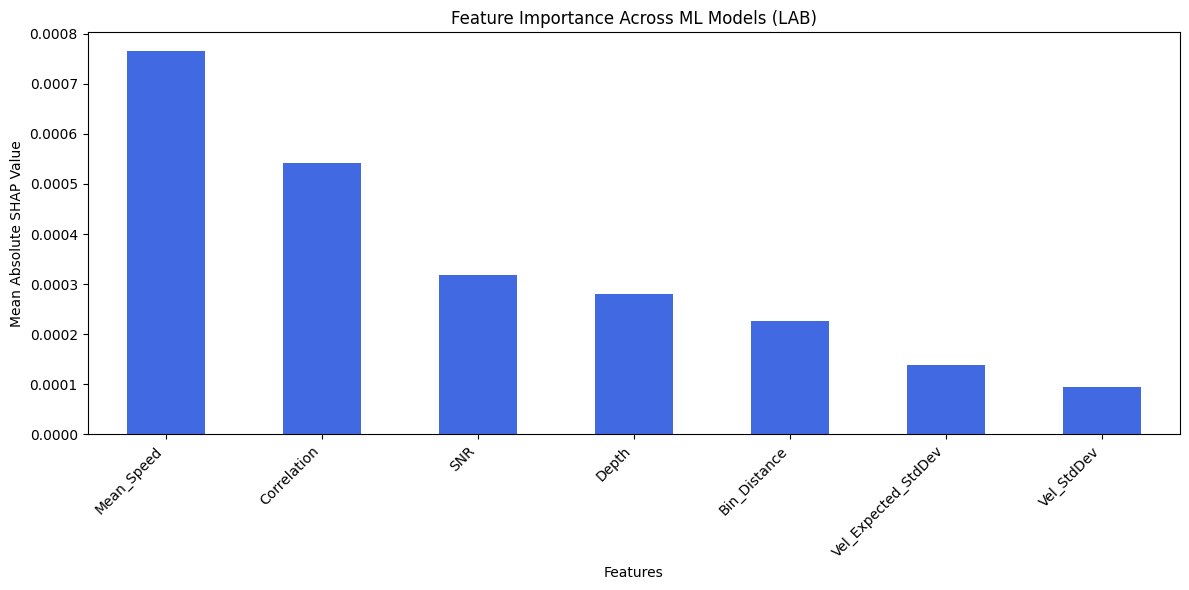

In [ ]:
import shap
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Compute SHAP Values & Feature Importance for All Models
feature_importance = {}

for name, model in models.items():
    print(f"\nComputing SHAP values for {name}...")

    try:
        # Tree-based models → Use TreeExplainer for efficiency
        if hasattr(model, "feature_importances_"):
            explainer = shap.TreeExplainer(model)
            shap_values = explainer.shap_values(X_test)
        
        # Non-tree models → Use KernelExplainer (approximate method)
        else:
            explainer = shap.KernelExplainer(model.predict, X_train[:50])  # Approximate method for non-tree models
            shap_values = explainer.shap_values(X_test[:50])  # Compute SHAP on test subset

        # Compute mean absolute SHAP values for each feature
        mean_shap_values = np.abs(shap_values).mean(axis=0)
        feature_importance[name] = mean_shap_values

    except Exception as e:
        print(f"Skipping SHAP for {name} due to: {str(e)}")

# Convert SHAP values into DataFrame
feature_importance_df = pd.DataFrame(feature_importance, index=X_test.columns)
feature_importance_df = feature_importance_df.mean(axis=1).sort_values(ascending=False)

# 📊 **Plot SHAP Feature Importance Across All Models**
plt.figure(figsize=(12, 6))
feature_importance_df.plot(kind='bar', color="royalblue")
plt.title('Feature Importance Across ML Models (LAB)')
plt.ylabel('Mean Absolute SHAP Value')
plt.xlabel('Features')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show() 